[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DeePTB-Lab/Recipes/blob/main/deeptb_tutorials/v2.2/DeePTB_Tutorial_1_Colab.ipynb)
[![GitHub](https://img.shields.io/badge/GitHub-DeePTB-blue)](https://github.com/deepmodeling/DeePTB)

---

## 🚀 Installation & Setup

This cell will automatically:
- Detect your environment (Colab/Binder/Local)
- Install DeePTB and all dependencies
- Download tutorial data files

> **💡 First-time setup takes 5-7 minutes. Please be patient!**

In [1]:
# Download and run the installation script
import os
from pathlib import Path

# Check if we're in Colab/Binder
IN_COLAB = 'google.colab' in __import__('sys').modules
IN_BINDER = 'BINDER_SERVICE_HOST' in os.environ

if IN_COLAB or IN_BINDER:
    # Download the installation script (always get the latest version)
    if Path('install_deeptb.py').exists():
        os.remove('install_deeptb.py')

    !wget -q https://raw.githubusercontent.com/DeePTB-Lab/Recipes/main/scripts/install_deeptb.py

    # Run the installation script
    %run install_deeptb.py
else:
    print("💻 Running locally - please ensure DeePTB is installed")
    print("See: https://github.com/deepmodeling/DeePTB#installation")


🔍 环境检测
✅ 检测到 Google Colab 环境

⚠️  DeePTB 未安装,开始安装流程...
⚠️  nvidia-smi 检测失败,尝试通过PyTorch检测...
💻 PyTorch未检测到GPU,使用 CPU 版本

📦 开始安装 DeePTB

[1/5] 安装 UV 包管理器...
✅ UV 安装完成

[2/5] 克隆 DeePTB 仓库...
✅ 仓库克隆完成

[3/5] 使用 UV 安装 DeePTB 及依赖...
⏳ 这可能需要几分钟,请耐心等待...
   正在安装:
   - PyTorch
   - torch_scatter
   - torch_geometric
   - e3nn
   - 其他依赖
📦 使用 PyG wheel: https://data.pyg.org/whl/torch-2.5.0+cpu.html
🚀 执行 uv sync...
✅ DeePTB 依赖安装完成 (Virtual Environment)

[3.5/5] 配置环境桥接...
🔍 DeePTB 根目录: /content/DeePTB
🔍 Venv 可执行路径: /content/DeePTB/.venv/bin/dptb
✅ 创建命令包装器: /usr/local/bin/dptb -> /content/DeePTB/.venv/bin/dptb
🔍 Venv 库路径: /content/DeePTB/.venv/lib/python3.10/site-packages
✅ 注入路径到系统: /usr/local/lib/python3.12/dist-packages/deeptb_venv.pth

[4/5] 验证安装...
✅ 命令行工具验证成功
✅ Python 导入验证成功: 2.2.1.dev22+gbd6677ab0

🎉 安装完成!

📥 下载教程数据文件...
✅ 数据文件下载完成
📂 当前工作目录: /content/Recipes/deeptb_tutorials/v2.2


* # DeePTB Tutorial 1: deeptb-sk baseline model  [v2.2]

<div style="color:black; background-color:#FFF3E9; border: 1px solid #FFE0C3; border-radius: 10px; margin-bottom:1rem">
    <p style="margin:1rem; padding-left: 1rem; line-height: 2.5;">
        Author: <a style="font-weight:normal" href="mailto:guqq@ustc.edu.cn">Gu, Qiangqiang 顾强强 📨 </a></b></i><br/>
        Date: 2025-04-20<br/>
        Protocol：<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License.</a></i><br/>
        Quick Start：Click the <span style="background-color:rgb(85, 91, 228); color:white; padding: 3px; border-radius: 5px;box-shadow: 2px 2px 3px rgba(0, 0, 0, 0.3); font-size:0.75rem;">Start Connection</span> button，then wait a moment to begin.
    </p>
</div>

## Introduction

**DeePTB** is a method that uses deep learning to accelerate first-principles electronic structure simulations.

### Version Features
- **v1**: Constructed tight-binding (TB) models with first-principles accuracy (DeePTB-SK)
- **v2**: Added E3 equivariant networks to represent single-electron operators (Hamiltonian, density matrix, and overlap matrix) (DeePTB-E3)
- **v2.2**: Incorporated built-in SK empirical parameters covering commonly used elements across the periodic table

Through these capabilities, DeePTB provides multiple approaches to accelerate electronic structure simulations of materials.

### Learning Objectives

In this tutorial, you will:
1. Learn how to use built-in base model to plot band structure for given crystal structure
2. Learn how to generate a empirical sk model in deeptb-sk format for target system

## 1. Calculating Band Structure for a Given Structure

The deeptb-sk module now [since v2.2] has built-in empirical SK parameter models covering elements across the periodic table.

These can be directly used to obtain empirical SKTB models for given structures. It also supports directly plotting band structures for a given structure.

In [2]:
pwd

'/content/Recipes/deeptb_tutorials/v2.2'

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
current_dir = os.getcwd()

In [4]:
workdir=f'{current_dir}/data/base_model/'
os.chdir(f"{workdir}/structures")
!ls

band_gaas  band_hBN  band_si  gaas.vasp  hBN.vasp  silicon.vasp


Run the band structure plotting command.
**Note** that the selection of high-symmetry paths in the Brillouin zone is based on the seekpath.get_path_orig_cell function, which has the following characteristics to be aware of:
1. It does not support 2D materials and will treat 2D materials as 3D materials
   
2. If the input cell is a non-standard primitive unit cell, the returned k path is equivalent to the k path for the standard cell. For example, the band structure calculated along the k path for the standard and non-standard unit cells will be the same up to numerical errors.
   
3. If the input cell is a supercell of a smaller primitive cell, the returned k path is that of the associated primitive cell, in the basis of supercell reciprocal lattice. In this case, the k points are not the high-symmetry points of the first Brillouin zone of the given supercell, but the high-symmetry points of the Brillouin zone of the associated primitive cell.

The command for plotting the band structure is as follows:

TBPLaS is not installed. Thus the TBPLaS is not available, Please install it first.
╭──────────────────────── Deep Learning Tight-Binding ─────────────────────────╮
│                                                                              │
│     ██████████                     ███████████  ███████████ ███████████      │
│    ░░███░░░░███                   ░░███░░░░░███░█░░░███░░░█░░███░░░░░███     │
│     ░███   ░░███  ██████   ██████  ░███    ░███░   ░███  ░  ░███    ░███     │
│     ░███    ░███ ███░░███ ███░░███ ░██████████     ░███     ░██████████      │
│     ░███    ░███░███████ ░███████  ░███░░░░░░      ░███     ░███░░░░░███     │
│     ░███    ███ ░███░░░  ░███░░░   ░███            ░███     ░███    ░███     │
│     ██████████  ░░██████ ░░██████  █████           █████    ███████████      │
│    ░░░░░░░░░░    ░░░░░░   ░░░░░░  ░░░░░           ░░░░░    ░░░░░░░░░░░       │
│                                                                              │
│                        

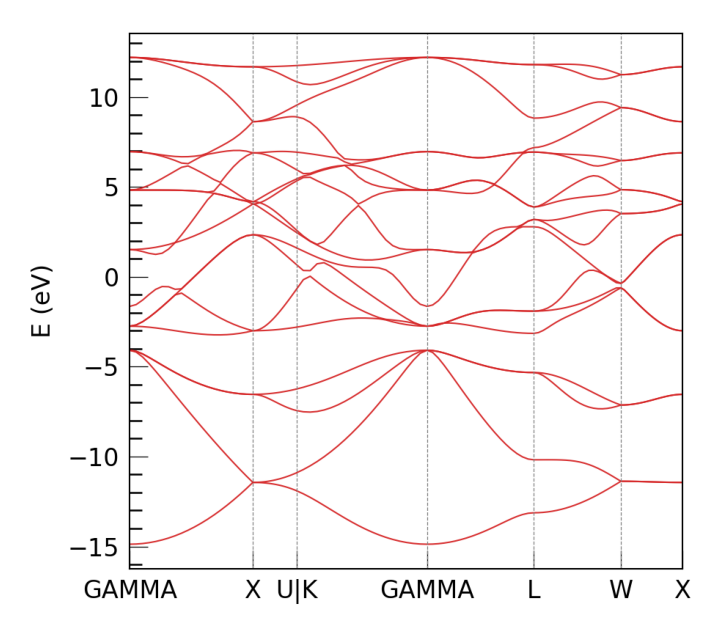

In [5]:
# 1. Silicon
!dptb run band -i poly4 -stu silicon.vasp -o band_si

plt.figure(figsize=(10, 8))
img = mpimg.imread('./band_si/results/band.png')
plt.imshow(img)
plt.axis('off')
plt.show()

TBPLaS is not installed. Thus the TBPLaS is not available, Please install it first.
╭──────────────────────── Deep Learning Tight-Binding ─────────────────────────╮
│                                                                              │
│     ██████████                     ███████████  ███████████ ███████████      │
│    ░░███░░░░███                   ░░███░░░░░███░█░░░███░░░█░░███░░░░░███     │
│     ░███   ░░███  ██████   ██████  ░███    ░███░   ░███  ░  ░███    ░███     │
│     ░███    ░███ ███░░███ ███░░███ ░██████████     ░███     ░██████████      │
│     ░███    ░███░███████ ░███████  ░███░░░░░░      ░███     ░███░░░░░███     │
│     ░███    ███ ░███░░░  ░███░░░   ░███            ░███     ░███    ░███     │
│     ██████████  ░░██████ ░░██████  █████           █████    ███████████      │
│    ░░░░░░░░░░    ░░░░░░   ░░░░░░  ░░░░░           ░░░░░    ░░░░░░░░░░░       │
│                                                                              │
│                        

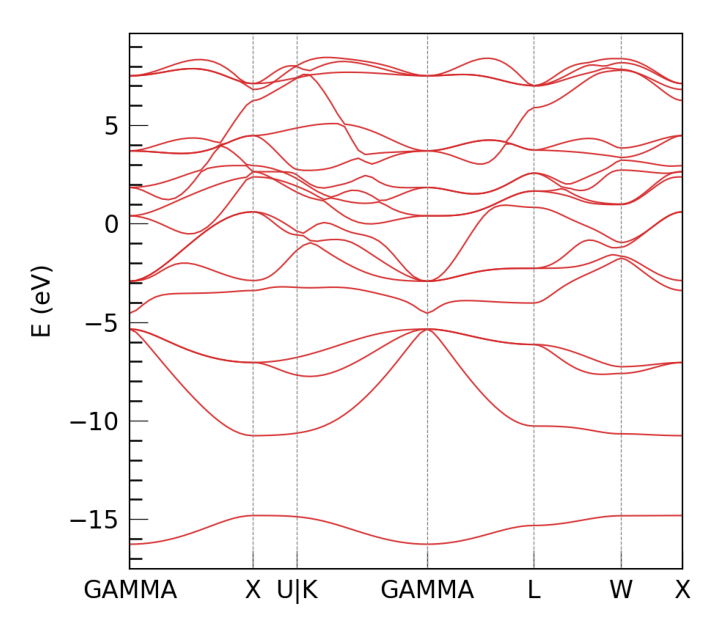

In [6]:
# 2. GaAs
!dptb run band -i poly4 -stu gaas.vasp -o band_gaas
# display the band plot:
plt.figure(figsize=(10, 8))
img = mpimg.imread('./band_gaas/results/band.png')
plt.imshow(img)
plt.axis('off')
plt.show()

TBPLaS is not installed. Thus the TBPLaS is not available, Please install it first.
╭──────────────────────── Deep Learning Tight-Binding ─────────────────────────╮
│                                                                              │
│     ██████████                     ███████████  ███████████ ███████████      │
│    ░░███░░░░███                   ░░███░░░░░███░█░░░███░░░█░░███░░░░░███     │
│     ░███   ░░███  ██████   ██████  ░███    ░███░   ░███  ░  ░███    ░███     │
│     ░███    ░███ ███░░███ ███░░███ ░██████████     ░███     ░██████████      │
│     ░███    ░███░███████ ░███████  ░███░░░░░░      ░███     ░███░░░░░███     │
│     ░███    ███ ░███░░░  ░███░░░   ░███            ░███     ░███    ░███     │
│     ██████████  ░░██████ ░░██████  █████           █████    ███████████      │
│    ░░░░░░░░░░    ░░░░░░   ░░░░░░  ░░░░░           ░░░░░    ░░░░░░░░░░░       │
│                                                                              │
│                        

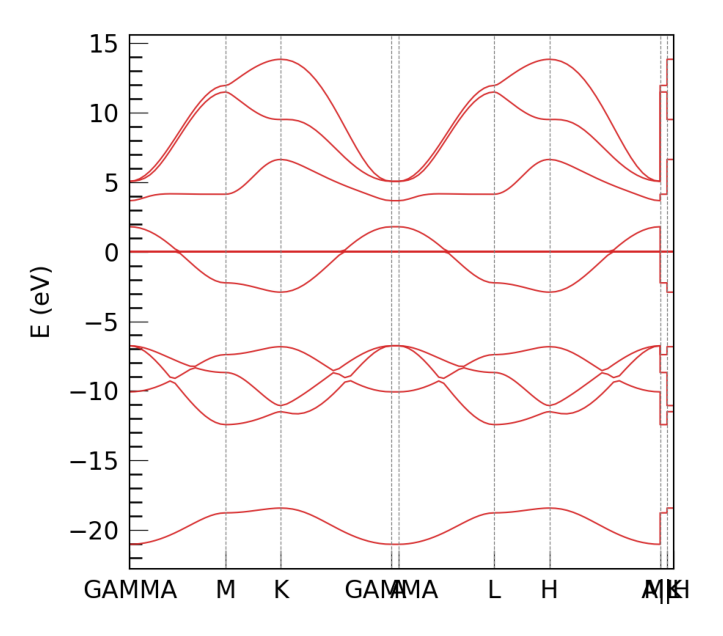

In [7]:
# 3. hBN 2D
!dptb run band -i poly4 -stu hBN.vasp -o band_hBN
# display the band plot:
plt.figure(figsize=(10, 8))
img = mpimg.imread('./band_hBN/results/band.png')
plt.imshow(img)
plt.axis('off')
plt.show()


## 2. Extracting SK Parameter Files for a Given System

Since there is a built-in baseline model covering the periodic table, for the target research system, you can extract the empirical parameter model for your target system from this built-in baseline model.

In [8]:
os.chdir(f"{workdir}/confs")
!ls

band_hBN   hbn_spd.json   hbn_sp.json	silicon.json
gaas.json  hbn_spd_model  hbn_sp_model


For the target system, we first need to define the basis set configuration and save it in a JSON file. Below is the configuration we use for hBN.

In [9]:
!cat hbn_spd.json

{
    "common_options": {
        "basis": {
            "B": ["s","p","d"],
            "N": ["s","p","d"]
        }
    }
}

Run the following command to extract the empirical model settings and parameters for the target system from the built-in empirical model covering the periodic table, and save them in the sktb.json file.

In [10]:
!dptb esk hbn_spd.json -m poly4 -o hbn_spd_model

TBPLaS is not installed. Thus the TBPLaS is not available, Please install it first.
╭──────────────────────── Deep Learning Tight-Binding ─────────────────────────╮
│                                                                              │
│     ██████████                     ███████████  ███████████ ███████████      │
│    ░░███░░░░███                   ░░███░░░░░███░█░░░███░░░█░░███░░░░░███     │
│     ░███   ░░███  ██████   ██████  ░███    ░███░   ░███  ░  ░███    ░███     │
│     ░███    ░███ ███░░███ ███░░███ ░██████████     ░███     ░██████████      │
│     ░███    ░███░███████ ░███████  ░███░░░░░░      ░███     ░███░░░░░███     │
│     ░███    ███ ░███░░░  ░███░░░   ░███            ░███     ░███    ░███     │
│     ██████████  ░░██████ ░░██████  █████           █████    ███████████      │
│    ░░░░░░░░░░    ░░░░░░   ░░░░░░  ░░░░░           ░░░░░    ░░░░░░░░░░░       │
│                                                                              │
│                        

The above command will create an hbn_spd_model folder and save the sktb.json model file in it.

In [11]:
!cat hbn_spd_model/sktb.json

{
    "version": 2,
    "unit": "eV",
    "model_options": {
        "nnsk": {
            "onsite": {
                "method": "uniform_noref"
            },
            "hopping": {
                "method": "poly4pow",
                "rs": {
                    "B-B": 4.22,
                    "B-N": 4.04,
                    "N-B": 4.04,
                    "N-N": 3.85
                },
                "w": 0.2
            },
            "soc": {},
            "freeze": false,
            "push": false,
            "std": 0.01,
            "atomic_radius": "cov"
        }
    },
    "common_options": {
        "basis": {
            "B": [
                "s",
                "p",
                "d"
            ],
            "N": [
                "s",
                "p",
                "d"
            ]
        },
        "dtype": "float32",
        "device": "cuda",
        "overlap": true
    },
    "model_params": {
        "onsite": {
            "B-s-0": [
            

**We can also load the generated sktb.json model file to plot the band structure:**

TBPLaS is not installed. Thus the TBPLaS is not available, Please install it first.
╭──────────────────────── Deep Learning Tight-Binding ─────────────────────────╮
│                                                                              │
│     ██████████                     ███████████  ███████████ ███████████      │
│    ░░███░░░░███                   ░░███░░░░░███░█░░░███░░░█░░███░░░░░███     │
│     ░███   ░░███  ██████   ██████  ░███    ░███░   ░███  ░  ░███    ░███     │
│     ░███    ░███ ███░░███ ███░░███ ░██████████     ░███     ░██████████      │
│     ░███    ░███░███████ ░███████  ░███░░░░░░      ░███     ░███░░░░░███     │
│     ░███    ███ ░███░░░  ░███░░░   ░███            ░███     ░███    ░███     │
│     ██████████  ░░██████ ░░██████  █████           █████    ███████████      │
│    ░░░░░░░░░░    ░░░░░░   ░░░░░░  ░░░░░           ░░░░░    ░░░░░░░░░░░       │
│                                                                              │
│                        

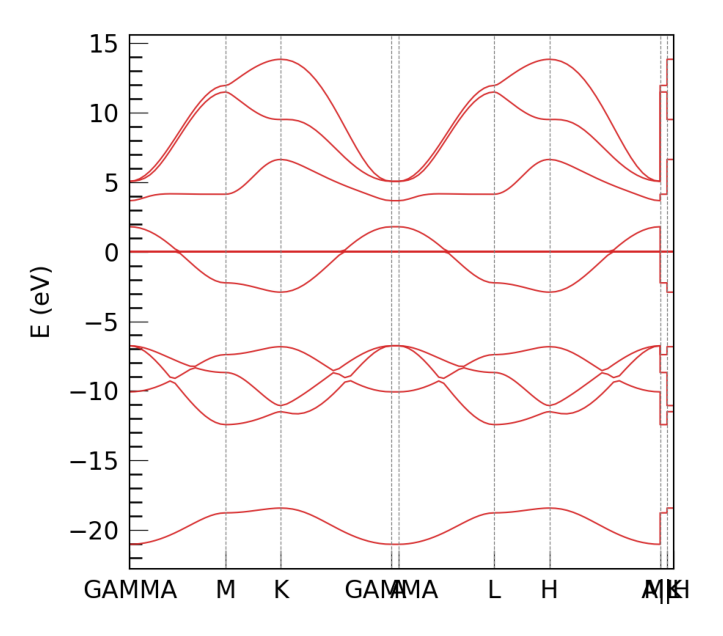

In [12]:
!dptb run band -i ./hbn_spd_model/sktb.json -stu ../structures/hBN.vasp -o band_hBN

# display the band plot:
plt.figure(figsize=(10, 8))
img = mpimg.imread('./band_hBN/results/band.png')
plt.imshow(img)
plt.axis('off')
plt.show()

We can see that the band structure is the same as before.

Here we can choose different basis settings, e.g. `hbn_sp.json` as the input config:
```json
{
    "common_options": {
        "basis": {
            "B": ["s","p"],
            "N": ["s","p"]
        }
    }
}
```

In [13]:
!dptb esk hbn_sp.json -m poly4 -o hbn_sp_model

TBPLaS is not installed. Thus the TBPLaS is not available, Please install it first.
╭──────────────────────── Deep Learning Tight-Binding ─────────────────────────╮
│                                                                              │
│     ██████████                     ███████████  ███████████ ███████████      │
│    ░░███░░░░███                   ░░███░░░░░███░█░░░███░░░█░░███░░░░░███     │
│     ░███   ░░███  ██████   ██████  ░███    ░███░   ░███  ░  ░███    ░███     │
│     ░███    ░███ ███░░███ ███░░███ ░██████████     ░███     ░██████████      │
│     ░███    ░███░███████ ░███████  ░███░░░░░░      ░███     ░███░░░░░███     │
│     ░███    ███ ░███░░░  ░███░░░   ░███            ░███     ░███    ░███     │
│     ██████████  ░░██████ ░░██████  █████           █████    ███████████      │
│    ░░░░░░░░░░    ░░░░░░   ░░░░░░  ░░░░░           ░░░░░    ░░░░░░░░░░░       │
│                                                                              │
│                        

TBPLaS is not installed. Thus the TBPLaS is not available, Please install it first.
╭──────────────────────── Deep Learning Tight-Binding ─────────────────────────╮
│                                                                              │
│     ██████████                     ███████████  ███████████ ███████████      │
│    ░░███░░░░███                   ░░███░░░░░███░█░░░███░░░█░░███░░░░░███     │
│     ░███   ░░███  ██████   ██████  ░███    ░███░   ░███  ░  ░███    ░███     │
│     ░███    ░███ ███░░███ ███░░███ ░██████████     ░███     ░██████████      │
│     ░███    ░███░███████ ░███████  ░███░░░░░░      ░███     ░███░░░░░███     │
│     ░███    ███ ░███░░░  ░███░░░   ░███            ░███     ░███    ░███     │
│     ██████████  ░░██████ ░░██████  █████           █████    ███████████      │
│    ░░░░░░░░░░    ░░░░░░   ░░░░░░  ░░░░░           ░░░░░    ░░░░░░░░░░░       │
│                                                                              │
│                        

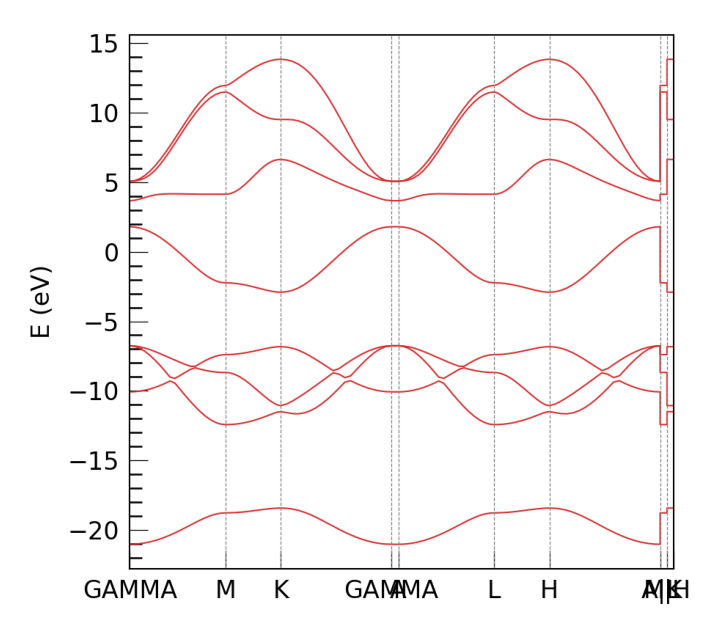

In [14]:
!dptb run band -i ./hbn_sp_model/sktb.json -stu ../structures/hBN.vasp -o band_hBN

# display the band plot:
plt.figure(figsize=(10, 8))
img = mpimg.imread('./band_hBN/results/band.png')
plt.imshow(img)
plt.axis('off')
plt.show()

It can be clearly seen that the bands near 0 eV are missing. This is because for the hBN system, our built-in empirical model parameters only include sp orbitals. The d orbital parameters are all set to 0 just to maintain a consistent format.

Similarly, we can obtain the corresponding model parameters for individual Si and GaAs systems. Readers are invited to explore this themselves.

<div style="color:black; background-color:#FFF3E9; border: 1px solid #FFE0C3; border-radius: 10px; margin-bottom:1rem">
    <p style="margin:1rem; padding-left: 1rem; line-height: 2.5;">
        Author: <a style="font-weight:normal" href="mailto:guqq@ustc.edu.cn">Gu, Qiangqiang : guqq@ustc.edu.cn</a>
    </p>
    <p style="margin:1rem; padding-left: 1rem; line-height: 2.5;">
        Thank you for reading!
    </p>
</div>